In [3]:
#imports

import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from numpy import reshape
%matplotlib inline

In [4]:
os.chdir("/Users/andrewcaffey/Documents/Projects/Data/PCPP/Part_Scraping/case/parts/")
part_list = []
comments = []
for i in os.listdir(os.getcwd()):
    a = open(i, 'r')
    #print a.read()
    b = BeautifulSoup(a)

    #basic info
    if b.find('h4', attrs={'class':'kind'}) != None:
        kind = b.find('h4', attrs={'class':'kind'}).text
        part_name = b.find('h1', attrs={'class':'name'}).text
        link = b.find('input', attrs={'name':'url'})['value']
        info_dict = {'Kind':kind, 'Name':part_name, 'Link': link}

        #prices
        if b.find_all('td', attrs={'class':'base'}) != None:
            price_list = b.find_all('td', attrs={'class':'base'})
            price_list = [float(x.text.strip('$')) for x in price_list]
            #average_price = sum(price_list)/len(price_list)
            price_dict = {'Prices':price_list,}

        #specs
        spec_labels = b.find('div', attrs={'class':'specs block'}).find_all('h4')
        spec_labels = [x.contents[0] for x in spec_labels]
        spec_values = str(b.find('div', attrs={'class':'specs block'}))

        vals = [x.strip().split('</h4>')[1].strip('\n').strip() for x in spec_values.split("<h4>")[1:]]
        vals[-1] = vals[-1].split('\n')[0]
        spec_values = vals

        spec_values = spec_values[0:len(spec_labels)+1]
        spec_dict = {spec_label:spec_value for spec_label, spec_value in zip(spec_labels,spec_values)}

        part_dict = dict(spec_dict.items() + info_dict.items() + price_dict.items())
        part_list.append(part_dict)

        #reviews
    reviews = b.find('div', attrs={'class':'part-reviews'})
    if reviews != None:
        reviews = reviews.find_all('div',attrs={'class':'part-review-block'})
        star_list = [len(reviews[x].find('ul',attrs={'class':'stars'}).find_all('li',attrs={'class':'full-star'})) for x in range(len(reviews))]

        comment_text_list = b.find_all('div', attrs={'class':'comment-message markdown'})
        comment_text_list = [comment_text_list[x].find_all('p') for x in range(len(comment_text_list))]

        comment_text_list_clean = []
        for i, x in enumerate(comment_text_list):
            comment = ""
            for y in x:
                try:
                    comment += y.contents[0] + " "
                except:
                    pass
            comment_text_list_clean.append(comment)

        

        review = zip(star_list, comment_text_list_clean)
        
        comments.append(review)

    a.close()
    b.decompose()

In [5]:
df = pd.DataFrame(part_list)

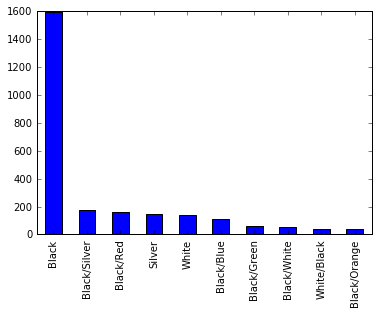

In [97]:
df.Color.value_counts()[0:10].plot(kind='bar')

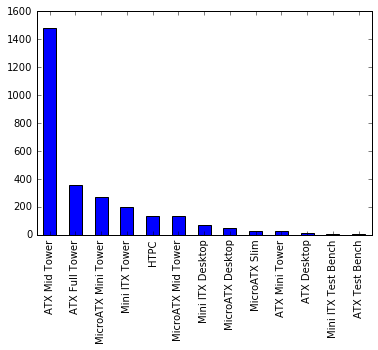

In [95]:
df.Type.value_counts().plot(kind='bar')

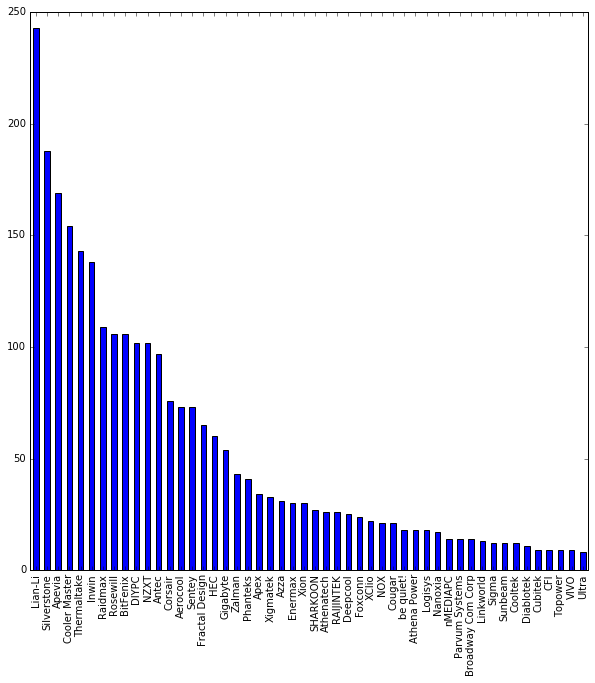

In [13]:
plt.figure(figsize=(10,10))
df.Manufacturer.value_counts()[0:50].plot(kind='bar')

In [14]:
df.columns

Index([                             Color,                         Dimensions,
                       External 2.5" Bays,                 External 3.5" Bays,
                      External 5.25" Bays,           External 5.25" Slim Bays,
       External 5.25" Slim Slot Load Bays,          Front Panel USB 3.0 Ports,
                    Includes Power Supply,                 Internal 2.5" Bays,
                       Internal 3.5" Bays,                Internal 5.25" Bays,
       Internal 5.25" Slim Slot Load Bays,                            u'Kind',
                                  u'Link',                       Manufacturer,
                Maximum Video Card Length,                              Model,
                Motherboard Compatibility,                            u'Name',
                                   Part #,                          u'Prices',
                                     Type],
      dtype='object')

In [19]:
df['avg'] = [sum(x)/len(x) if len(x) != 0 else 0 for x in df.Prices]

(array([  29.,  125.,  194.,  125.,  116.,   81.,   82.,   39.,   49.,
          34.,   37.,   18.,   13.,   11.,    6.,   21.,    5.,    2.,
           4.,    2.,    2.,    3.,    3.,    2.,    1.,    1.,    3.,
           1.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    2.]),
 array([  20.99 ,   35.465,   49.94 ,   64.415,   78.89 ,   93.365,
         107.84 ,  122.315,  136.79 ,  151.265,  165.74 ,  180.215,
         194.69 ,  209.165,  223.64 ,  238.115,  252.59 ,  267.065,
         281.54 ,  296.015,  310.49 ,  324.965,  339.44 ,  353.915,
         368.39 ,  382.865,  397.34 ,  411.815,  426.29 ,  440.765,
         455.24 ,  469.715,  484.19 ,  498.665,  513.14 ,  527.615,
         542.09 ,  556.565,  571.04 ,  585.515,  599.99 ]),
 <a list of 40 Patch objects>)

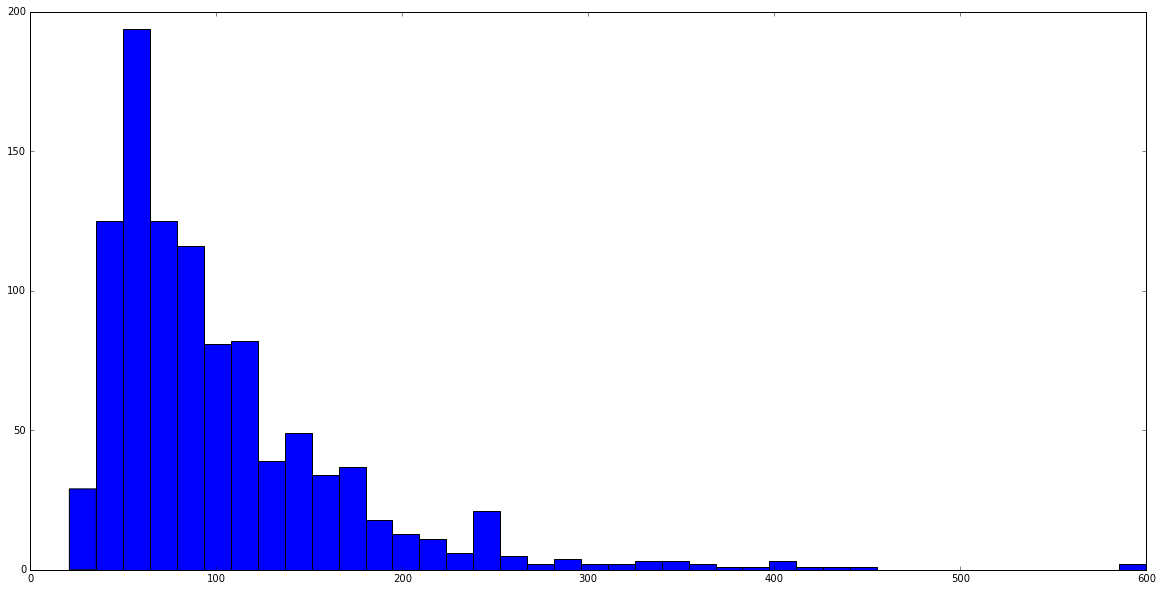

In [25]:
plt.figure(figsize=(20,10))
plt.hist(df.avg[df.avg>0], bins=40)

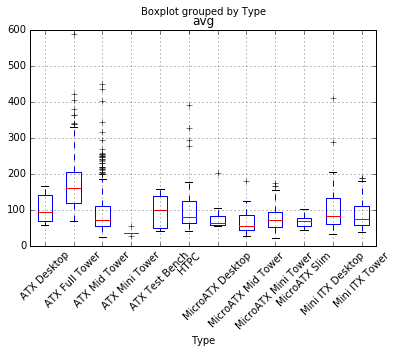

In [29]:
df[df.avg>0].boxplot(column='avg', by='Type', rot=45)

In [64]:
#plot volume against price
df['dim'] = [re.sub(r'"', '', x) if type(x)==str else None for x in df.Dimensions]
df['dim'] = [re.sub(r' ', '', x) if type(x)==str else None for x in df.dim]
df['dim'] = [x.split('x') if type(x)==str else None for x in df.dim]
df['vol'] = [float(x[0])*float(x[1])*float(x[2]) if type(x)==list else None for x in df.dim]
df.vol = [x if x != np.nan else 0 for x in df.vol]
df.vol = df.vol.fillna(0)

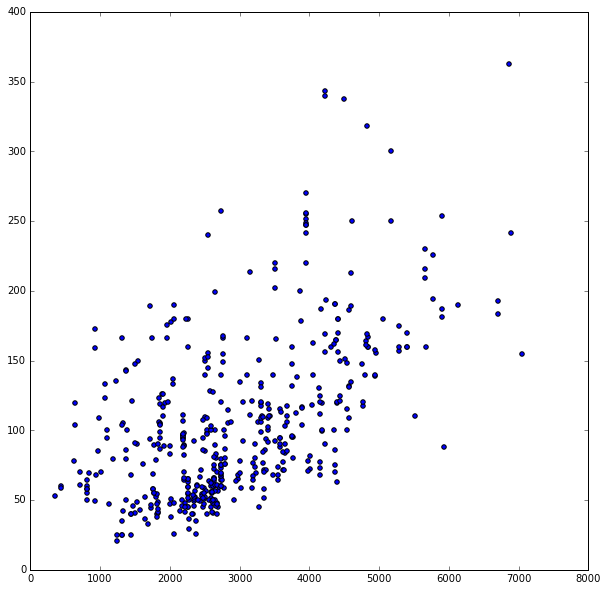

In [93]:
plt.figure(figsize=(10,10))
plt.axis([0,8000,0,400])
x = df.vol[(df.vol>0) & (df.avg>0)]
y = df.avg[(df.vol>0) & (df.avg>0)]
plt.scatter(x, y)

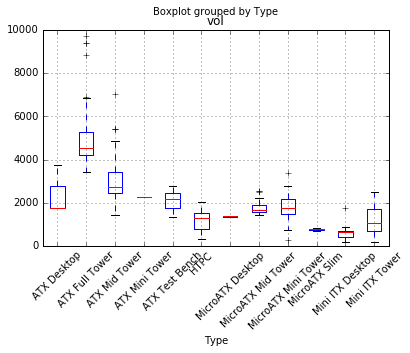

In [84]:
df[(df.vol>0)&(df.avg>0)].boxplot(column='vol', by='Type', rot=45)